# User app behavior analysis for food startup company app

### Project description

In this project I, as a worker for a food startup company, am going to investigate user behavior for the company app. My analysis will have two main goals:
1. Investigate user behavior, study user funnel, find out how users reach the purchase stage, how many users actually make it to this stage and how many get stuck at previous stages.
2. Analyse results of A/A/B test, that was conducted to find out if changing app fonts can increase conversion.

### Table of Contents

* [Step 1. Data Preprocessing](#chapter1)
 
* [Step 2. Study and check the data](#chapter2) 
    * [How many events are in the logs?](#section_2_1)
    * [How many users are in the logs? What's the average number of events per user?](#section_2_2)
    * [What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time](#section_2_3)
    * [Make sure you have users from all three experimental groups.](#section_2_3)
    * [Conclusion](#section_2_4)
* [Step 3. Study the event funnel](#chapter3)
    * [See what events are in the logs and their frequency of occurrence. Sort them by frequency](#section_3_1)
    * [Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.](#section_3_2)
    * [In what order do you think the actions took place. Are all of them part of a single sequence?](#section_3_3)
    * [Use the event funnel to find the share of users that proceed from each stage to the next.](#section_3_4)
    * [At what stage do you lose the most users? What share of users make the entire journey from their first event to payment?](#section_3_5)
    * [Conclusion](#section_3_6)
* [Step 4. Study the results of the experiment](#chapter4)
    * [How many users are there in each group?](#section_4_1)
    * [We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.](#section_4_2)
    * [Check for statistically significant difference between control groups and group with altered fonts.](#section_4_3)
    * [Conclusion](#section_4_4)
* [General Conclusion](#chapter5)
 

## Step 1. Data Preprocessing <a class="anchor" id="chapter1"></a>


In [1]:
#load libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import numpy as np
import pandas as pd
import seaborn as sns
import math as mth
import warnings; warnings.simplefilter('ignore')
import plotly.express as px
!pip install -q usaddress 
import usaddress


from functools import reduce
from math import factorial
from scipy import stats as st
from statistics import mean 
from IPython.display import display
from plotly import graph_objects as go

pd.set_option('display.max_columns', 500)

In [2]:
#load dataset 
#logs = pd.read_csv('/datasets/logs_exp_us.csv', sep="\t") #for platform
logs = pd.read_csv('./logs_exp_us.csv', sep="\t") #for platform
#logs = pd.read_csv('logs_exp_us.csv', sep="\t") #for local use local
logs.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
48259,MainScreenAppear,436679880444653381,1564735147,248
59581,MainScreenAppear,3579460024691788772,1564754291,248
24171,CartScreenAppear,5547467181852761286,1564669938,246
24616,CartScreenAppear,2555214839587509656,1564670524,248
5506,MainScreenAppear,1453298361789539604,1564637314,247
233811,MainScreenAppear,378761015309962378,1565191239,248
32470,MainScreenAppear,4972984422817814446,1564681790,246
78781,MainScreenAppear,7272615589134403622,1564815483,247
24750,PaymentScreenSuccessful,596478621289313372,1564670703,247
10967,MainScreenAppear,8120185919191035504,1564649400,246


In [3]:
#rename columns
logs.columns = ['event', 'uid', 'timestamp', 'expid']

In [4]:
logs.info()
display(logs.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   uid        244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   expid      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event,uid,timestamp,expid
count,244126,2.441260e+05,2.441260e+05,244126.000000
unique,5,NaN,NaN,NaN
top,MainScreenAppear,NaN,NaN,NaN
freq,119205,NaN,NaN,NaN
mean,NaN,4.627568e+18,1.564914e+09,247.022296
std,NaN,2.642425e+18,1.771343e+05,0.824434
min,NaN,6.888747e+15,1.564030e+09,246.000000
25%,NaN,2.372212e+18,1.564757e+09,246.000000
50%,NaN,4.623192e+18,1.564919e+09,247.000000
75%,NaN,6.932517e+18,1.565075e+09,248.000000


In [5]:
#convert  columns to right formats
logs['datetime'] = pd.to_datetime(logs.timestamp, unit='s')
logs['expid'] = logs.expid.astype('category')
logs['event'] = logs.event.astype('category')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  category      
 1   uid        244126 non-null  int64         
 2   timestamp  244126 non-null  int64         
 3   expid      244126 non-null  category      
 4   datetime   244126 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 6.1 MB


Add a separate column for dates.

In [6]:
logs['date'] = logs.datetime.astype('datetime64[D]')

In [7]:
logs.sample(5)

,event,uid,timestamp,expid,datetime,date
208551,PaymentScreenSuccessful,951001704752844842,1565116289,246,2019-08-06 18:31:29,2019-08-06
162625,MainScreenAppear,2857677218503028985,1565016122,247,2019-08-05 14:42:02,2019-08-05
179352,MainScreenAppear,6627774947018286010,1565066543,246,2019-08-06 04:42:23,2019-08-06
178458,CartScreenAppear,7528470328317847905,1565063212,248,2019-08-06 03:46:52,2019-08-06
90425,MainScreenAppear,5718835579824401175,1564834604,248,2019-08-03 12:16:44,2019-08-03


### Conclusion

I've got a dataframe that has 244126 entries. There are 5 types of events and 3 test groups.
In this part I have changed formats of different columns and added dae column.

## Step 2. Study and check the data <a class="anchor" id="chapter2"></a>


### How many events are in the logs? <a class="anchor" id="section_2_1"></a>


In [8]:
logs.event.count()

244126

In [9]:
logs.event.value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64

There is total of 244126 events, they are sepparated in 5 groups.

### How many users are in the logs? What's the average number of events per user? <a class="anchor" id="section_2_2"></a>


In [10]:
print ('There are',logs.uid.nunique(), 'users in the logs.')

There are 7551 users in the logs.


In [11]:
print ('On average user has {:.1f} events.'.format(logs.groupby('uid')['event'].count().mean()))

On average user has 32.3 events.


### What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. <a class="anchor" id="section_2_3"></a>

In [12]:
print ('Maximum date:',logs.date.min())
print ('Minumum date:',logs.date.max())
print ('This data covers {:.0f} days of events'.format((logs.datetime.max()-logs.datetime.min()).round('1D').days))

Maximum date: 2019-07-25 00:00:00
Minumum date: 2019-08-07 00:00:00
This data covers 14 days of events


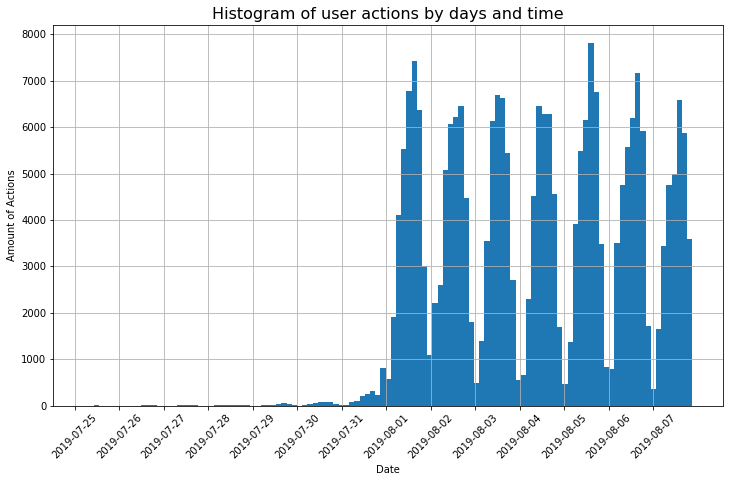

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
logs.datetime.hist(ax=ax, bins='auto')
ax.set_xlabel('Date')
ax.set_ylabel('Amount of Actions')
ax.set_title('Histogram of user actions by days and time',fontsize=16)
plt.xticks(pd.date_range(start="2019-07-25",end="2019-08-07").tolist(), rotation=45)
plt.show()

From this graph I see that here there are some dates on which there hasn't been a lot of action. Older events could end up in some users' logs for technical reasons. I'll drop all the rows with actions that happened before August, 1st.

In [14]:
logs_clean = logs[logs['date'] >="2019-08-01"]
print ('Clean data covers {:.0f} days of events'.format((logs_clean.datetime.max()-logs_clean.datetime.min()).round('1D').days))

Clean data covers 7 days of events


#### Did you lose many events and users when excluding the older data?


In [15]:
print('By cleaning the data I have lost {:.2%} of data, which is {:.0f} rows.'
      .format((1-logs_clean.shape[0]/logs.shape[0]),(logs.shape[0]-logs_clean.shape[0])))


By cleaning the data I have lost 1.16% of data, which is 2828 rows.


That's a pity that I had to drop this data, but it's less than 5% of all the data and it was necessary for this data analysis.

### Make sure you have users from all three experimental groups. <a class="anchor" id="section_2_4"></a>


In [16]:
logs_clean.expid.value_counts()

248    84726
246    79425
247    77147
Name: expid, dtype: int64

I for sure have users from all three experimental groups. Now let's check how many rows were dropped from each group.

In [17]:
logs.expid.value_counts()-logs_clean.expid.value_counts()

248    1021
246     879
247     928
Name: expid, dtype: int64

Event though amount of dropped rows differs, it's good that there was pretty simillar amount of rows dropped from each dataset.

### Conclusion <a class="anchor" id="section_2_5"></a>

Here I have discovered that:
1. There are 7551 total users in logs;
2. On average one user makes 32.3 events;
3. There are 14 days in original dataframe, but only data since August, 1st seems to be usable;
4. All experimental groups have simillar number of entries.

## Step 3. Study the event funnel <a class="anchor" id="chapter3"></a>

### See what events are in the logs and their frequency of occurrence. Sort them by frequency. <a class="anchor" id="section_3_1"></a>



In [18]:
logs_clean.event.value_counts()

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

There are 5 different events in the startup app. The most popular one is main display appear, the event that has occured the least is tutorial. Seems like not many users get there, this may be due to the fact that <i>Tutorial</i> isn't a part of shopping funnel, it might be an extra action, that you can do if you want to get additional info.

### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once. <a class="anchor" id="section_3_2"></a>

In [19]:
#find how many unique users have performed each event
user_event = (logs_clean
              .groupby('event')
              .agg(unique_users=('uid','nunique'))
              .reset_index()
              .sort_values('unique_users', ascending=False)
             )
user_event

,event,unique_users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


So here I see that there are 7419 users who have seen main screen, 4593 have recieved offers screen, 3734 have got to their shopping cart, 3539 have made a payment on the webside and 840 have seen tutorial. Now let's find total number of users.

In [20]:
print ('Number of users:', logs_clean.uid.nunique())

Number of users: 7534


There are more than a hundred users who have had some action, but have not been to main screen, this looks a little bit weird. Let's have a look at them.

In [21]:
users_from_main_screen = logs_clean.query('event == "MainScreenAppear"')['uid'].unique()
logs_clean.query('uid not in @users_from_main_screen').groupby('event').agg(unique_users=('uid','nunique')).reset_index()

,event,unique_users
0,CartScreenAppear,99
1,MainScreenAppear,0
2,OffersScreenAppear,111
3,PaymentScreenSuccessful,98
4,Tutorial,4


Maybe it's a system bug or maybe there is a possibility to get to other screens without ever getting. In real life case I would have checked that with developers.

Now let's find ratio of users who users who have performed each action to all users.

In [22]:
user_event['user_ratio'] = user_event['unique_users'] / logs_clean.uid.nunique()
user_event

,event,unique_users,user_ratio
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


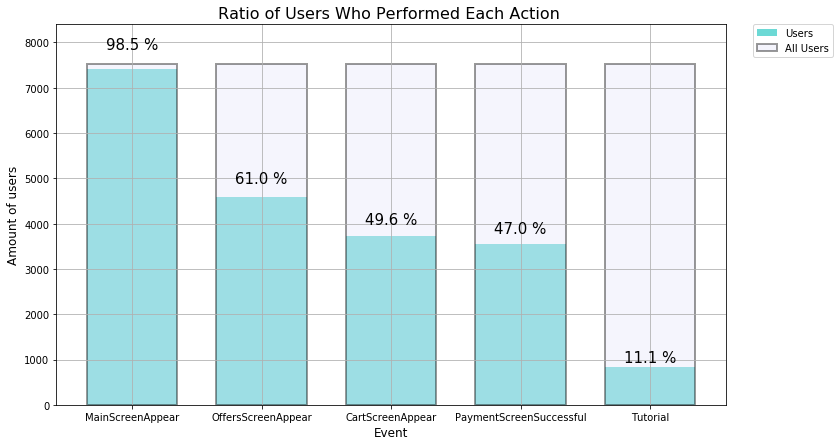

In [23]:
# define colors
colors = ['lightblue', 'mediumturquoise', 'orange', 'lightgreen', 'plum', 'bisque','lavender',
          'lightcyan','palevioletred']
#define axes
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Ratio of Users Who Performed Each Action ',fontsize=16)
plt.xlabel('Event',fontsize=12)
plt.ylabel('Amount of users',fontsize=12)

#plot
g = plt.bar(user_event['event'], user_event['unique_users'],
        0.7, label='Users',color=colors[1], alpha=0.8)
g1 = plt.bar(user_event['event'], logs_clean.uid.nunique(), 0.7,
     label='All Users', color=colors[6], alpha=0.4, edgecolor='black',linewidth=2)

#values for fillig the bars
bar_label = (user_event['user_ratio']*100).round(1).tolist() 
bar_label = [str(label) for label in bar_label]

#add percentages
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx]+" %",
                ha='center', va='bottom', rotation=0, size=15)
autolabel(g)  
plt.ylim(0,8400)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

Here I see that 98,4 all users have been to main screen, and for the folowing events amount of users that got there declines. Tutorial continue to be an exception with small percentage of users there.


Now let's find ratio of users who have performed more than one action, compared to all users.

In [24]:
#get amount of events for each type of event for each user and
df = logs_clean.groupby(['event','uid']).agg(events_per_user=('timestamp','nunique')).reset_index()

#get total amount of users with more than one action and all unique users to one dataframe
result = pd.merge(df.query('events_per_user > 1') #get users, who have had more than one event
                  .groupby('event')
                  .agg(active_users=('uid','count')) #get total number of these users
                  .reset_index(),
                  df.groupby('event').agg(unique_users=('events_per_user','count')).reset_index() 
                  , on=['event']) #merge with total number of unique users
result['active_users_ratio'] = result['active_users'] /  result['unique_users'] #add ratio
result

,event,active_users,unique_users,active_users_ratio
0,CartScreenAppear,3262,7534,0.432971
1,MainScreenAppear,7173,7534,0.952084
2,OffersScreenAppear,3912,7534,0.519246
3,PaymentScreenSuccessful,2965,7534,0.393549
4,Tutorial,84,7534,0.011149


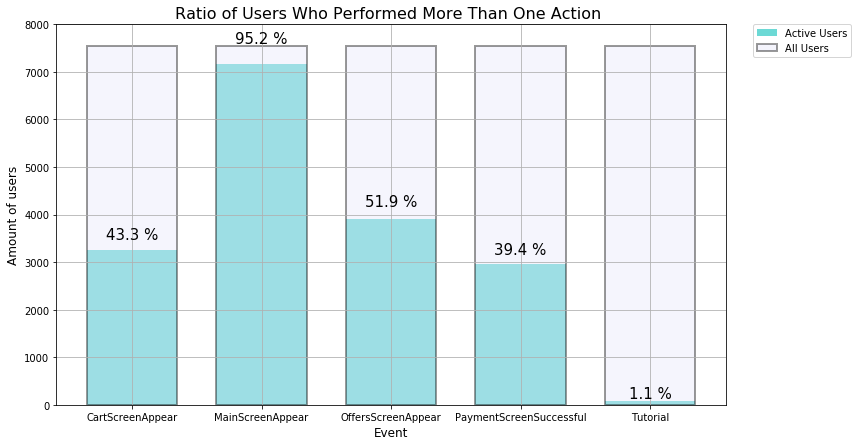

In [25]:

#define axes
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Ratio of Users Who Performed More Than One Action ',fontsize=16)
plt.xlabel('Event',fontsize=12)
plt.ylabel('Amount of users',fontsize=12)

#plot
g = plt.bar(result['event'], result['active_users'],
        0.7, label='Active Users',color=colors[1], alpha=0.8)
g1 = plt.bar(result['event'], result['unique_users'], 0.7,
     label='All Users', color=colors[6], alpha=0.4, edgecolor='black',linewidth=2)

#values for fillig the bars
bar_label = (result['active_users_ratio']*100).round(1).tolist() 
bar_label = [str(label) for label in bar_label]

#add percentages
autolabel(g)  
plt.ylim(0,8000)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

Here I see that many users have one action happenening more than once. Except for tutorial, it continues to be unique action, that only some users come to and 90% of these users get there only once.

### In what order do you think the actions took place. Are all of them part of a single sequence? <a class="anchor" id="section_3_3"></a>


From performed analysis it's obvious that <i>Tutorial</i> isn't part of the same sequenca as other events. From what I see the order of events in event funnel should look like this:

<center><b><i> MainScreenAppear ——> OffersScreenAppear ——> CartScreenAppear ——> PaymentScreenSuccessful </i></b></center>

But also offers shouldn't be neccesary, everything can work without them, so I'll make funnel even smaller:

<center><b><i> MainScreenAppear ——> CartScreenAppear ——> PaymentScreenSuccessful </i></b></center>


### Use the event funnel to find the share of users that proceed from each stage to the next.  <a class="anchor" id="section_3_4"></a>

First let's get first of each event for all users.

In [26]:
df = (logs_clean
      .groupby(['uid','event'])[['datetime']].min()
      .reset_index()
      .query('event.astype("str") != "Tutorial" and event.astype("str") != "OffersScreenAppear"')
      .pivot_table(columns='event',index='uid',values='datetime', aggfunc='min')
     )
df = df.rename(columns=str).reset_index()
df = df[['uid','MainScreenAppear','CartScreenAppear','PaymentScreenSuccessful']]


In [27]:
df

event,uid,MainScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,6888746892508752,2019-08-06 14:06:34,NaT,NaT
1,6909561520679493,2019-08-06 18:52:54,2019-08-06 18:52:58,2019-08-06 18:52:58
2,6922444491712477,2019-08-04 14:19:33,2019-08-04 14:19:40,2019-08-04 14:19:40
3,7435777799948366,2019-08-05 08:06:34,NaT,NaT
4,7702139951469979,2019-08-01 04:29:54,2019-08-02 14:28:45,2019-08-02 14:28:45
...,...,...,...,...
7513,9217594193087726423,NaT,2019-08-02 09:00:58,2019-08-02 09:00:57
7514,9219463515465815368,2019-08-05 05:26:26,2019-08-06 16:49:40,2019-08-06 16:52:16
7515,9220879493065341500,2019-08-02 17:58:48,2019-08-02 17:59:16,NaT
7516,9221926045299980007,2019-08-01 17:30:27,NaT,NaT


Now let's clear the data, so we will only have users who have been to main screen and who also have got to other screens after they'd got to main.

In [28]:
def sanity_check (row):
    #clear rows that don't have visit to main screen and rows that had entrance to the cart or 
    #payment before visit to main screen
    if pd.isnull(row['MainScreenAppear']) == True: return False
    elif row['MainScreenAppear'] > row['CartScreenAppear'] or row['MainScreenAppear'] > row['PaymentScreenSuccessful']:
            return False
    else: return True
    

In [29]:
df['sanity_check'] = df.apply(sanity_check, axis=1)
funnel = df.query('sanity_check ==True')[['uid','MainScreenAppear','CartScreenAppear','PaymentScreenSuccessful']]
funnel.head()

event,uid,MainScreenAppear,CartScreenAppear,PaymentScreenSuccessful
0,6888746892508752,2019-08-06 14:06:34,NaT,NaT
1,6909561520679493,2019-08-06 18:52:54,2019-08-06 18:52:58,2019-08-06 18:52:58
2,6922444491712477,2019-08-04 14:19:33,2019-08-04 14:19:40,2019-08-04 14:19:40
3,7435777799948366,2019-08-05 08:06:34,NaT,NaT
4,7702139951469979,2019-08-01 04:29:54,2019-08-02 14:28:45,2019-08-02 14:28:45


### At what stage do you lose the most users? What share of users make the entire journey from their first event to payment?  <a class="anchor" id="section_3_5"></a>

In [30]:
print (funnel.MainScreenAppear.count(), 'users start by getting to the main screen.')
print ('Out of them only {:.0f} get to Shopping Cart screen. That is {:.2%} of users, who have been to main screen.'
       .format(funnel.CartScreenAppear.count(), funnel.CartScreenAppear.count()/funnel.MainScreenAppear.count()))
print ('Out of them only {:.0f} succeed with payment. That is {:.2%} of users, who got to Shopping Cart and {:.2%} of users who have been to main screen.'
      .format(funnel.PaymentScreenSuccessful.count(),funnel.PaymentScreenSuccessful.count()/funnel.CartScreenAppear.count(),
             funnel.PaymentScreenSuccessful.count()/funnel.MainScreenAppear.count()))

7213 users start by getting to the main screen.
Out of them only 3430 get to Shopping Cart screen. That is 47.55% of users, who have been to main screen.
Out of them only 3239 succeed with payment. That is 94.43% of users, who got to Shopping Cart and 44.91% of users who have been to main screen.


So most of our users get lost in transaction from main screen to shopping cart screen. Actually most of the users who get to shopping cart tend to make entire journey. But group result is a little worse. Just 44.91% of all users get to the very end. But that's actually really good conversion.

A good way to increase this conversion might be increasing number of users, who see offers screen, or maybe send notifications to users, who have been to main screen, but haven't proceeded.

### Conclusion <a class="anchor" id="section_3_6"></a>

By performing funnel analysis I have found out several things:
1. Tutorial is an optional page, that gets visited only by 10% of users;
2. Most of users get to Main Screen, but only 61% see Offers screen appear;
3. 48% of users who have been to the main screen get to shopping cart afterwards;
4. 94% of users who get to shopping cart sooner or later proceen with their payment.

## Step 4. Study the results of the experiment <a class="anchor" id="chapter4"></a>

### How many users are there in each group? <a class="anchor" id="section_4_1"></a>

In [31]:
logs_clean.groupby('expid').agg(unique_users=('uid','nunique')).reset_index()

,expid,unique_users
0,246,2484
1,247,2513
2,248,2537


There's similar amount of users in each group, so I will carry on with the test.

### We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247. <a class="anchor" id="section_4_2"></a>

first let's create pivot table of amount of users on different stages for all samples.

In [32]:
exp_results = logs_clean.pivot_table(index=logs_clean['event'].astype("str"), values='uid', columns='expid', aggfunc='nunique')
exp_results


expid,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


So here I will first be checking if there is a statistical difference between groups 246 and 247 in conversion aka proportion:


"Is the share of users (from all users in the test) that had "CartScreenAppear","MainScreenAppear", etc. of test group <u><b>246</b></u> statistically different from share of users from group <u><b>247</b></u>?"

To do that I will use the text of proportions, or z-score. My H0 will be: 

<u>"Share of users in group 246 for each category <b>is not</b> different from share of users in group 247 for each category."</u>

And alternative hypothesys will be:

<u>"Share of users in group 246 for each category <b>is</b>  different from share of users in group 247 for each category."</u>

In [33]:
def check_hypothesis(group1,group2, event, alpha=0.05):
    
    #get success for each group
    successes1=exp_results[exp_results.index == event][group1].iloc[0]
    successes2=exp_results[exp_results.index == event][group2].iloc[0]
    
    #for trials take the data from original df or used a pre-aggregated data
    trials1=logs_clean[logs_clean.expid==group1]['uid'].nunique()
    trials2=logs_clean[logs_clean.expid==group2]['uid'].nunique()
    
    
     #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = st.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2,'\n')

I'm going to use Holm method to calculate significance level this test for my test to have higher power. I'm going to perform 15 tests, and I want my total significance level to be 0.05. So I'll get me a list of alphas for all the tests.

In [34]:
#define significance level for each event
def holm_method_calc(total_alpha, number_of_tests):
    counter = 0
    alpha = []
    for m in range(0, number_of_tests):
        a = a = total_alpha / (number_of_tests-counter) 
        counter += 1
        alpha.append(a)
    return alpha

In [35]:
#get list of alphas for final significance level of 0.15 and 15 total tests.
alpha_15_exp = holm_method_calc(0.05, 15)

In [36]:
test_counter = 0
for i in exp_results.index.tolist():
    check_hypothesis(246,247, i, alpha=alpha_15_exp[test_counter])
    test_counter +=1
    
#save sounter for the next test
test_checkpoint = test_counter


p-value:  0.22883372237997213
Fail to Reject H0 for CartScreenAppear and groups 246 247 

p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247 

p-value:  0.2480954578522181
Fail to Reject H0 for OffersScreenAppear and groups 246 247 

p-value:  0.11456679313141849
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247 

p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247 



That is great result! It means that our A/A test doesn't show statistical difference between our 2 control groups, that means that groups that have recieved the same fonts show simillar result. So I can proceed to testing of groups with alterating fonts.

### Check for statistically significant difference between control groups and group with altered fonts. <a class="anchor" id="section_4_3"></a>


Here I'll perform 2 tests for finding difference between each control group and test group.

First I'll compare group 246 and group 248. My H0 will be: 

<u>"Share of users in group 246 for each category <b>is not</b> different from share of users in group 248 for each category."</u>

My alternative hypothesis will be:

<u>"Share of users in group 246 for each category <b>is</b> different from share of users in group 248 for each category."</u>

In [37]:
#get counter value from previos test
test_counter = test_checkpoint

for i in exp_results.index.tolist():
    check_hypothesis(246,248, i, alpha=alpha_15_exp[test_counter])
    test_counter +=1

#save sounter for the next test
test_checkpoint = test_counter

p-value:  0.07842923237520116
Fail to Reject H0 for CartScreenAppear and groups 246 248 

p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248 

p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248 

p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248 

p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248 



#### Conclusion
That means that there isn't any statisticaly significant difference between group 246 with old fonts and group 248 with new fonts.

Now let's compare group 247 with test group 248. My H0 will be: 

<u>"Share of users in group 247 for each category is not different from share of users in group 248 for each category."</u>

My alternative hypothesis will be:

<u>"Share of users in group 247 for each category <b>is</b> different from share of users in group 248 for each category."</u>

In [38]:
#get counter value from previos test
test_counter = test_checkpoint

for i in exp_results.index.tolist():
    check_hypothesis(247,248, i, alpha=alpha_15_exp[test_counter])
    test_counter +=1

p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248 

p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248 

p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248 

p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248 

p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248 



#### Conclusion
That means that there isn't any statisticaly significant difference between group 247 with old fonts and group 248 with new fonts.

### Conclusion <a class="anchor" id="section_4_4"></a>

After conducting all these test I can say with 95% certainty that there wasn't any statistically significant difference of conversion between group that got new fonts and groups that stayed with the old ones. So the company can ether keep the old fonts or change to new ones, it's unlikely to make any difference.

## Step 5. General conclusion <a class="anchor" id="chapter5"></a>

After conducting this analysis I have come to these results:
1. Most of users get to Main Screen, but only 61% see Offers screen appear;
3. 48% of users who have been to the main screen get to shopping cart afterwards;
4. 94% of users who get to Shopping Cart sooner or later proceen with their payment;
5. It may be a good idea to send notifications to users who have been to main screen, but haven't proceeded;
6. After analysing test results I have found out that with 95% certainty changing fonts doesnt affect app conversion, i.e. we can proceed ether with old fonts or with new ones.